<a href="https://colab.research.google.com/github/ikalmalik/Colab-and-JupyterNotebook/blob/main/Monitoring_Indeks_Klorofil_(NDCI)_menggunakan_Citra_Sentinel_2A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import geemap
import ee

In [ ]:
! pip install xee
import xee

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.2 MB/s eta 0:00:00


In [ ]:
import ee
ee.Authenticate()
ee.Initialize(
    project='gee-malikzone',
    opt_url='https://earthengine-highvolume.googleapis.com')

In [ ]:
from ipyleaflet import SearchControl

# Inisialisasi peta dunia (bebas)
map = geemap.Map(center=[0, 0], zoom=2)

# Tambahkan Search bar tanpa marker
search_control = SearchControl(
    position="topleft",
    url='https://nominatim.openstreetmap.org/search?format=json&q={s}',
    zoom=12,  # Zoom level saat lokasi ditemukan
    property_name='display_name',
    marker=None  # TANPA marker
)

# Tambahkan ke peta
map.add_control(search_control)

# Tampilkan peta
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
roi = map.draw_last_feature.geometry()
roi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Feature.geometry",
    "arguments": {
      "feature": {
        "functionInvocationValue": {
          "functionName": "Feature",
          "arguments": {
            "geometry": {
              "functionInvocationValue": {
                "functionName": "GeometryConstructors.Polygon",
                "arguments": {
                  "coordinates": {
                    "constantValue": [
                      [
                        [
                          97.073656,
                          1.18283
                        ],
                        [
                          97.073656,
                          1.238436
                        ],
                        [
                          97.114339,
                          1.238436
                        ],
                        [
                          97.114339,
                          1.18283
                        ],
                        [
                          97.073656,
                          1.18283
                        ]
                      ]
                    ]
                  },
                  "geodesic": {
                    "constantValue": false
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

In [ ]:
# Fungsi join diperbaiki
def join_cloud_probability(s2_sr, s2_cloud):
    innerJoin = ee.Join.inner()
    filterTimeEq = ee.Filter.equals(leftField='system:index', rightField='system:index')

    joined = innerJoin.apply(s2_sr, s2_cloud, filterTimeEq)

    def mergeBands(pair):
        sr = ee.Image(pair.get('primary'))
        cloud = ee.Image(pair.get('secondary'))
        return sr.addBands(cloud.select('probability'))

    return ee.ImageCollection(joined.map(mergeBands))  # <-- fix di sini


# Fungsi masking awan canggih
def mask_clouds(image):
    cloud_prob = image.select('probability')
    qa = image.select('QA60')

    cloudMask = cloud_prob.lt(60)  # probabilitas awan < 60%
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    qaMask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))

    mask = cloudMask.And(qaMask)

    return image.updateMask(mask)

# Fungsi perhitungan NDWI dan NDCI
def index(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    mndwi = image.normalizedDifference(['B3', 'B11']).rename('MNDWI')
    andwi = image.normalizedDifference(['B3', 'B5']).rename('ANDWI')
    ndpi = image.normalizedDifference(['B2', 'B6']).rename('NDPI')  # Near dry pixel index
    fndwi = image.normalizedDifference(['B3', 'B11']).rename('FNDWI')  # sering setara dengan MNDWI

    # AWEI (shallow dan non-shallow)
    awei_sh = image.expression(
        'B1 + 2.5*B2 - 1.5*(B4 + B5) - 0.25*B7',
        {
            'B1': image.select('B1'),
            'B2': image.select('B2'),
            'B4': image.select('B4'),
            'B5': image.select('B5'),
            'B7': image.select('B7'),
        }
    ).rename('AWEIsh')

    awei_nsh = image.expression(
        '4*(B3 - B8) - (0.25*B11 + 2.75*B12)',
        {
            'B3': image.select('B3'),
            'B8': image.select('B8'),
            'B11': image.select('B11'),
            'B12': image.select('B12'),
        }
    ).rename('AWEInsh')

    wri = image.expression(
        '(B3 + B4) / (B2 + B8)',
        {
            'B2': image.select('B2'),
            'B3': image.select('B3'),
            'B4': image.select('B4'),
            'B8': image.select('B8'),
        }
    ).rename('WRI')

    wi = image.expression(
        '(B3 + B4) / (B5 + B6)',
        {
            'B3': image.select('B3'),
            'B4': image.select('B4'),
            'B5': image.select('B5'),
            'B6': image.select('B6'),
        }
    ).rename('WI')

    ndci = image.normalizedDifference(['B8', 'B4']).rename('NDCI')

    # Gabungan mask air (bisa dikustom threshold-nya)
    water_mask = ndwi.gt(0).And(mndwi.gt(0)).And(andwi.gt(0)).And(fndwi.gt(0))\
        .And(awei_sh.gt(0)).And(awei_nsh.gt(0)).And(wi.gt(1)).And(wri.gt(1)).And(ndpi.gt(0))

    return image.addBands([
        ndwi, mndwi, andwi, ndpi, fndwi,
        awei_sh, awei_nsh, wi, wri,
        ndci.updateMask(water_mask).rename('NDCI_masked')
    ]).copyProperties(image, ['system:time_start', 'system:time_end'])


# Ambil koleksi S2 dan cloud prob
s2_sr = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate('2018-01-01', '2025-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .filterBounds(roi)

s2_cloud = ee.ImageCollection("COPERNICUS/S2_CLOUD_PROBABILITY") \
    .filterDate('2018-01-01', '2025-12-31') \
    .filterBounds(roi)

# Gabungkan, masking awan, hitung NDWI & NDCI
dataset = join_cloud_probability(s2_sr, s2_cloud) \
    .map(mask_clouds) \
    .map(index)


In [ ]:
def iwt(image, date_str):
    return image.set('system:time_start', ee.Date(date_str).millis())

# 6. Komposit dengan waktu tertentu
A1 = iwt(dataset.filterDate('2018-01-01', '2019-12-31').median(), '2018-06-01')
A2 = iwt(dataset.filterDate('2018-01-01', '2019-12-31').median(), '2018-12-31')
A3 = iwt(dataset.filterDate('2018-01-01', '2019-12-31').median(), '2019-06-01')
A4 = iwt(dataset.filterDate('2018-01-01', '2019-12-31').median(), '2019-12-31')
A5 = iwt(dataset.filterDate('2018-01-01', '2020-12-31').median(), '2020-06-01')
A6 = iwt(dataset.filterDate('2019-01-01', '2020-12-31').median(), '2020-12-31')
A7 = iwt(dataset.filterDate('2021-01-01', '2022-12-31').median(), '2021-06-01')
A8 = iwt(dataset.filterDate('2021-01-01', '2022-12-31').median(), '2021-12-31')
A9 = iwt(dataset.filterDate('2022-01-01', '2023-12-31').median(), '2022-06-01')
A10 = iwt(dataset.filterDate('2022-01-01', '2023-12-31').median(), '2022-12-31')
A11 = iwt(dataset.filterDate('2023-01-01', '2023-12-31').median(), '2023-06-01')
A12 = iwt(dataset.filterDate('2023-01-01', '2023-12-31').median(), '2023-12-31')
A13 = iwt(dataset.filterDate('2024-01-01', '2024-12-31').median(), '2024-06-01')
A14 = iwt(dataset.filterDate('2024-01-01', '2024-12-31').median(), '2024-12-31')
A15 = iwt(dataset.filterDate('2024-01-01', '2025-06-20').median(), '2025-06-01')

# 7. Gabungkan jadi ImageCollection dan klip ke ROI
composite = ee.ImageCollection([A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, A15])
composite1 = composite.map(lambda img: img.clip(roi))

In [ ]:
import xarray as xr
ds = xr.open_dataset(composite1, engine = 'ee', crs = 'EPSG:4326', scale = 0.0001, geometry = roi)

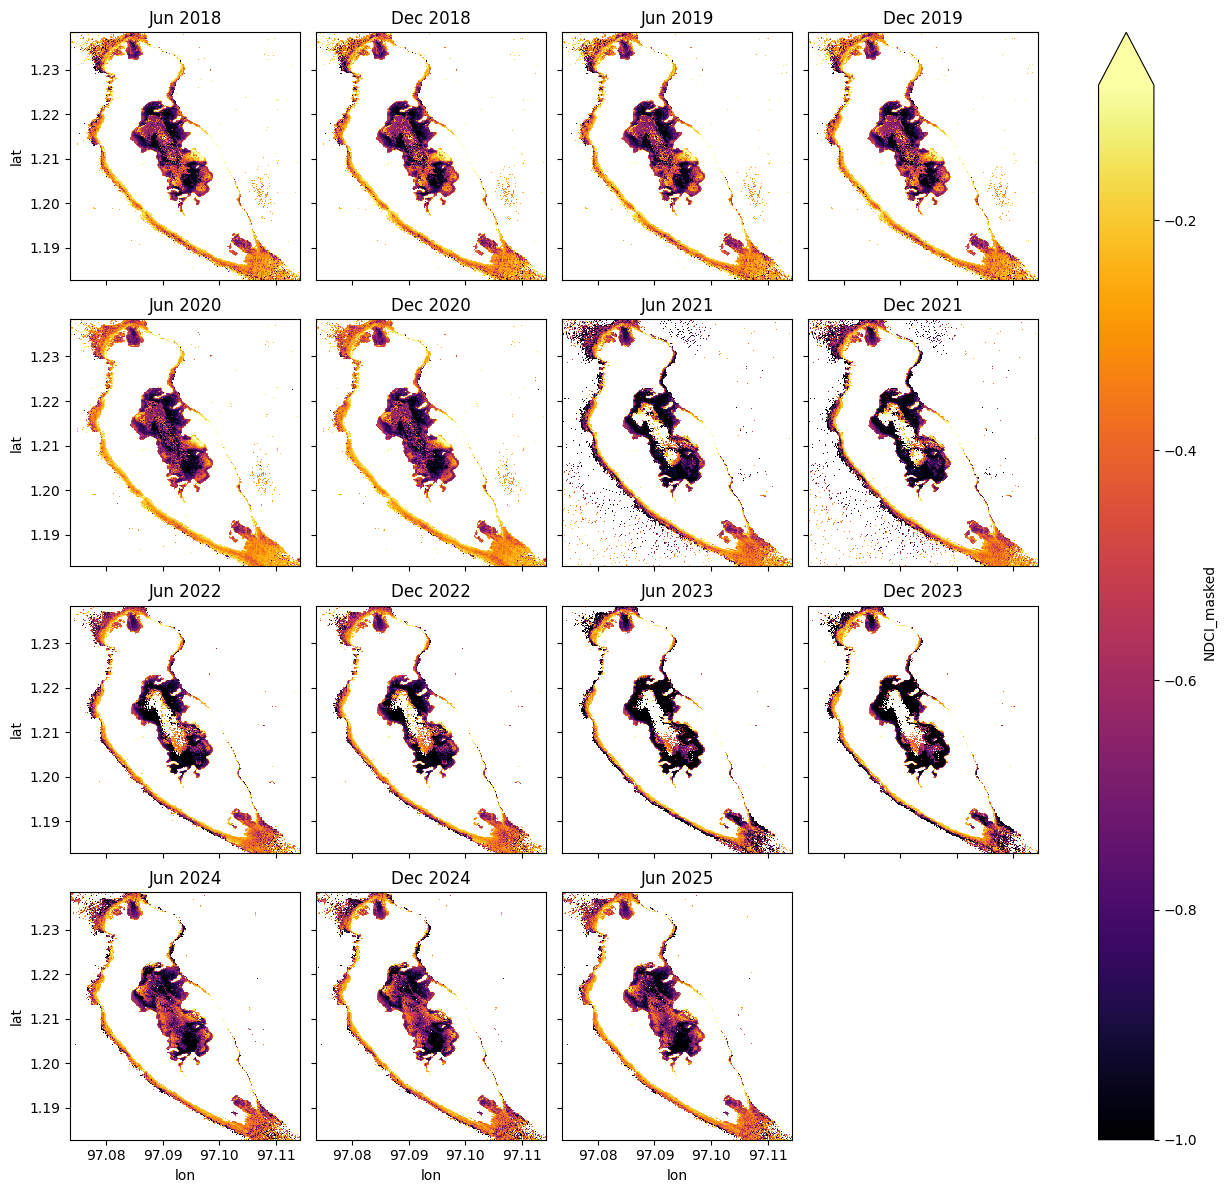

In [ ]:
vhi_array = ds['NDCI_masked'].values
lon = ds['NDCI_masked'].coords['lon'].values  # panjang 135
lat = ds['NDCI_masked'].coords['lat'].values  # panjang 123

tahun_labels = ["Jun 2018", "Dec 2018", "Jun 2019",
                "Dec 2019", "Jun 2020", "Dec 2020",
				        "Jun 2021", "Dec 2021", "Jun 2022",
                "Dec 2022", "Jun 2023", "Dec 2023",
                "Jun 2024", "Dec 2024", "Jun 2025"]
ds_label = xr.DataArray(
    data=vhi_array,
    coords={'time': tahun_labels, 'lon': lon, 'lat': lat},
    dims=['time', 'lon', 'lat'],
    name='NDCI_masked'
)

g = ds_label.plot(
    x='lon', y='lat',
    col='time', col_wrap=4,
    cmap='inferno', robust=True,
    add_colorbar=True
)

for ax, label in zip(g.axes.flat, tahun_labels):
    ax.set_title(label)

In [ ]:
import matplotlib.pyplot as plt
plt.savefig("NDCI_masked.png", dpi=800, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>